Begin by importing all necessary libraries and allowing us to view all dataframe columns.

In [1]:
! pip install geopandas

  Using cached geopandas-0.14.3-py3-none-any.whl (1.1 MB)
  Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl (15.7 MB)
  Using cached shapely-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
  Using cached pyproj-3.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)


In [2]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
pd.set_option('display.max_columns', None)

Then import all data files.

In [3]:
demo_ref_raw = pd.read_csv('demographicref.csv') #demographic reference data
econ_ref_raw = pd.read_csv('econref.csv') #economic reference data
health_expen_raw = pd.read_csv('healthexpenditure.csv') #healthcare expenditure data
health_qual_raw = pd.read_csv('healthquality.csv') #healthcare quality data
health_resor_raw = pd.read_csv('healthresources.csv') #healthcare resources data
health_util_raw = pd.read_csv('healthutil.csv') #healthcare utilization data
social_proc_raw = pd.read_csv('socialprotection.csv') #social healthcare protection data
worker_migr_raw = pd.read_csv('healthworkmigration.csv') #healthcare worker migration data

The final dataset cannot be loaded past the 284,614th line, so in order to avoid having partial data on one variable we needed to cut the last 40,000 or so entries.

In [4]:
health_stat_raw = pd.read_csv('healthstatus.csv',nrows = 284583) #health status data

Remove unwanted columns of data.

In [5]:
demo_ref_col = demo_ref_raw[['Variable','Measure','Country','Year','Value']]
econ_ref_col = econ_ref_raw[['Variable', 'Measure', 'Country','Year', 'Value']]
health_expen_col = health_expen_raw[['Financing scheme', 'Function','Provider', 'Measure', 'Country', 'Year', 'Unit', 'Value']]
health_qual_col = health_qual_raw[['Country','Periods','Indicator','Gender','Age Group','Value','Value.1']]
health_resor_col = health_resor_raw[['Variable','Measure','Country','Year','Value']]
health_util_col = health_util_raw[['Variable','Measure','Country','Year','Value']]
social_proc_col = social_proc_raw[['Variable','Measure','Country','Year','Value']]
worker_migr_col = worker_migr_raw[['Country','Variable','Country of origin','Year','Value']]
health_stat_col = health_stat_raw[['Variable','Measure','Country','Year','Value']]

Remove unwanted rows of data. Typically rows containing data measured in units that cannot be compared between countries (e.g. in local currency or raw numbers of incidents). Also removing rows containing variables with few observations or which are unlikely to be helpful for our purposes. Not all data sets required this.

In [6]:
econ_ref_clean = econ_ref_col.loc[(econ_ref_col['Measure']=='National currency unit per US$, PPP')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')|
                       (econ_ref_col['Measure']=='Million US$ at exchange rate')|
                       (econ_ref_col['Measure']=='/capita, US$ exchange rate ')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')]

health_expen_clean = health_expen_col.loc[(health_expen_col['Measure']=='Share of gross domestic product')|
                       (health_expen_col['Measure']=='Constant prices, OECD base year')|
                       (health_expen_col['Measure']=='Share of current expenditure on health')|
                       (health_expen_col['Measure']=='Per capita, current prices, current PPPs')]

health_qual_clean = health_qual_col.loc[((health_qual_col['Value']=='Age-sex standardised rate per 100 000 population')|
               (health_qual_col['Value']=='Age-sex standardised rate per 100 patients')|
               (health_qual_col['Value']=='Age-standardised survival (%)'))|
               (health_qual_col['Value']=='Rate per 100 deaths (%)')|
               (health_qual_col['Value']=='Crude rate per 100 patients')|
               (health_qual_col['Value']=='Age-sex standardised ratio')|
               (health_qual_col['Value']=='Age-standardised survival (%)')|
               (health_qual_col['Value']=='Ratio')|
               (health_qual_col['Gender']=='Total')] 

health_qual_clean = health_qual_clean.drop(list((health_qual_clean.loc[(health_qual_clean['Periods']=="2000-2004")|
                                                                      (health_qual_clean['Periods']=="2005-2009")|
                                                                      (health_qual_clean['Periods']=="2010-2014")|
                                                                      (health_qual_clean['Periods']=="2015-2019")]).index.values)) 

health_resor_clean = health_resor_col.loc[(health_resor_col['Measure']=='Density per 1 000 population (head counts)')|
                (health_resor_col['Measure']=='Per million population')|
                (health_resor_col['Measure']=='% of total physicians (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 population')|
                (health_resor_col['Measure']=='% of physicians (head counts)')|
                (health_resor_col['Measure']=='Per 100 000 population')|
                (health_resor_col['Measure']=='% of total hospital employment (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 live births')|
                (health_resor_col['Measure']=='Salaried, income, US$ exchange rate')] 

health_util_clean = health_util_col.loc[(health_util_col['Measure']=='Per 100 000 population')|
               (health_util_col['Measure']=='% performed as inpatient cases')|
               (health_util_col['Measure']=='% performed as day cases')|
               (health_util_col['Measure']=='Per 100 000 females')|
               (health_util_col['Measure']=='Inpatient cases per 100 000 population ')|
               (health_util_col['Measure']=='Total procedures per 100 000 population')|
               (health_util_col['Measure']=='Day cases per 100 000 population')|
               (health_util_col['Measure']=='Per 1 000 population')|
               (health_util_col['Measure']=='% of children immunised')|
               (health_util_col['Measure']=='Waiting times from specialist assessment to treatment: Mean (days)')|
               (health_util_col['Measure']=='Waiting times of patients on the list: % of all patients waiting more than 3 months')|
               (health_util_col['Measure']=='Waiting times of patients on the list: Mean (days)')]

social_proc_clean = social_proc_col.loc[(social_proc_col['Measure']=='% of total population')|
                                        (social_proc_col['Measure']=='% of total population covered')] 

health_stat_clean = health_stat_col.loc[(health_stat_col['Measure']=='Deaths per 100 000 females (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 females (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 females, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 males, aged 75 years old')|
               (health_stat_col['Measure']=='Years lost, /100 000 population, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (crude rates)')|
               (health_stat_col['Measure']=='% of population (crude rate)')|
               (health_stat_col['Measure']=='Years')|
               (health_stat_col['Measure']=='Incidence per 100 000 population')|
               (health_stat_col['Measure']=='Deaths per 1 000 live births')]

Next we want to remove from the other dataframes all the countries which are not in the migration dataframe. We specifically select countries with sufficient number of observations. To do this we define a function that lists the countries with sufficient migration data and then filter the other dataframes to remove observations of countries not in the list.

In [7]:
migr_list = []
for country in worker_migr_col["Country"]:
    if (worker_migr_col["Country"].value_counts()[country] > 50) and (country not in migr_list):
        migr_list.append(country)

In [8]:
econ_ref_clean = econ_ref_clean.loc[(econ_ref_clean["Country"].isin(migr_list))]
demo_ref_clean = demo_ref_col.loc[(demo_ref_col["Country"].isin(migr_list))]
health_expen_clean = health_expen_clean.loc[(health_expen_clean["Country"].isin(migr_list))]
health_qual_clean = health_qual_clean.loc[(health_qual_clean["Country"].isin(migr_list))]
health_resor_clean = health_resor_clean.loc[(health_resor_clean["Country"].isin(migr_list))]
health_util_clean = health_util_clean.loc[(health_util_clean["Country"].isin(migr_list))]
social_proc_clean = social_proc_clean.loc[(social_proc_clean["Country"].isin(migr_list))]
health_stat_clean = health_stat_clean.loc[(health_stat_clean["Country"].isin(migr_list))]

Lastly before pivoting we want to reset all the indexes.

In [9]:
econ_ref_clean = econ_ref_clean.reset_index()
demo_ref_clean = demo_ref_clean.reset_index()
health_expen_clean = health_expen_clean.reset_index()
health_qual_clean = health_qual_clean.reset_index()
health_resor_clean = health_resor_clean.reset_index()
health_util_clean = health_util_clean.reset_index()
social_proc_clean = social_proc_clean.reset_index()
health_stat_clean = health_stat_clean.reset_index()

Next we have to pivot the dataframes, and merge the reference data.

In [10]:
worker_migr = worker_migr_col.pivot_table(index = ['Year','Country'], columns = ['Variable'], values = 'Value')
demo_ref = demo_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
econ_ref = econ_ref_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_expen = health_expen_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Function'], values = 'Value')
health_qual = health_qual_clean.pivot_table(index = ['Periods','Country','Age Group'], columns = ['Value','Indicator'], values = 'Value.1')
health_resor = health_resor_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_util = health_util_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
social_proc = social_proc_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')
health_stat = health_stat_clean.pivot_table(index = ['Year','Country'], columns = ['Measure','Variable'], values = 'Value')

reference = pd.merge(demo_ref,econ_ref, on = ['Year','Country'])

## Relationship Between Health Outcome and Migration of Healthcare Providers 
**Preliminary Analysis**

1. Measures of Healthcare Quality
Mortality rate, hospital readmission rate

In [11]:
mor_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 patients"
hos_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 000 population" #Measure of mortality rate and hospital admission/readmission rate
doc_val = health_qual_clean["Value"] == "Crude rate per 100 patients"
doc_gender = health_qual_clean["Gender"] == "Total"

health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])
yrs =  health_qual_clean["Periods"] > 2014

mor_ind = health_qual_clean["Indicator"].str.contains("mortality")
re_hos_ind = health_qual_clean["Indicator"].str.contains("hospital readmission")
doc_val_ind = health_qual_clean["Indicator"].str.contains("spending enough time with patients during the consultation")

qual_mor = health_qual_clean[mor_ind & yrs & mor_val]
qual_re_hos = health_qual_clean[re_hos_ind & yrs & hos_val]
qual_doc= health_qual_clean[doc_val_ind & yrs & doc_val & doc_gender ]


mor_countries = set(qual_mor['Country'].unique())
re_hos_countries = set(qual_re_hos['Country'].unique())
doc_countries = set(qual_doc['Country'].unique())

common_countries = mor_countries & re_hos_countries & doc_countries #filtering out countries wit

qual_mor_filtered = qual_mor[qual_mor['Country'].isin(common_countries)]
qual_re_hos_filtered = qual_re_hos[qual_re_hos['Country'].isin(common_countries)]
qual_doc_filtered = qual_doc[qual_doc['Country'].isin(common_countries)]

In [12]:
summary_qual_mor = pd.DataFrame(qual_mor_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Mortality'})
summary_qual_re_hos = pd.DataFrame(qual_re_hos_filtered .groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Admission'})
summary_qual_doc =  pd.DataFrame(qual_doc_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Enough Consultation Time'})

In [13]:
bad_health = pd.DataFrame(health_stat["% of population (crude rate)"]["Bad/very bad health, total aged 15+"]).rename(columns={'Bad/very bad health, total aged 15+': 'Bad Health'})
bad_health = bad_health[bad_health.index.get_level_values('Year') > 2014]
bad_health_filterd = bad_health[bad_health.index.get_level_values('Country').isin(common_countries)]

summary_bad_health = pd.DataFrame(bad_health_filterd.groupby(['Country'])['Bad Health'].mean()) 

In [14]:
age_ref = pd.DataFrame(reference["% of total population"]["Population: 65 years old and over"])
age_ref = age_ref[age_ref.index.get_level_values('Year') > 2014]
age_ref_filtered = age_ref[age_ref.index.get_level_values('Country').isin(common_countries)]

age_summary = pd.DataFrame(age_ref_filtered.groupby("Country").mean())

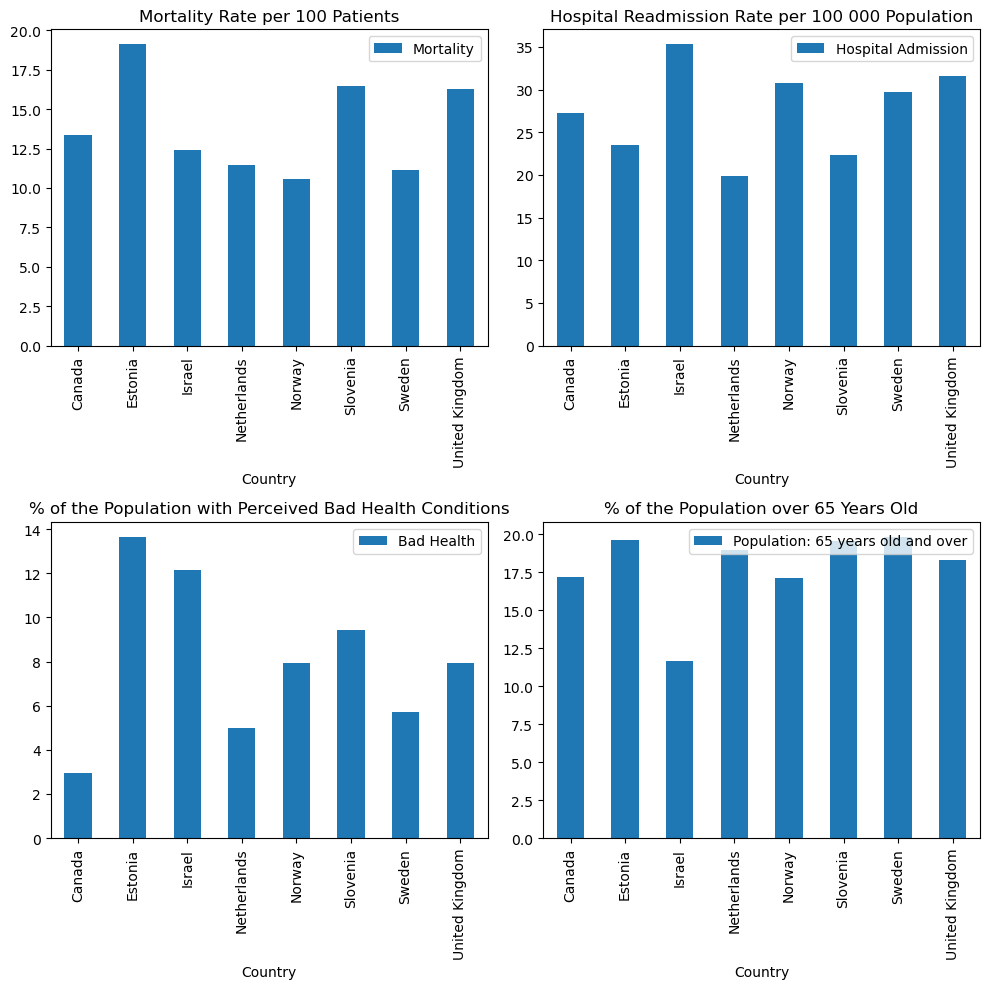

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0] = summary_qual_mor.plot.bar(ax=ax[0,0])
ax[0, 0].set_title("Mortality Rate per 100 Patients")
ax[0, 1] = summary_qual_re_hos.plot.bar(ax=ax[0, 1])
ax[0, 1].set_title("Hospital Readmission Rate per 100 000 Population")
ax[1, 0] = summary_bad_health.plot.bar(ax=ax[1,0])
ax[1, 0].set_title("% of the Population with Perceived Bad Health Conditions")
ax[1, 1] = age_summary.plot.bar(ax = ax[1,1])
ax[1, 1].set_title("% of the Population over 65 Years Old")
plt.tight_layout()

### Health Workforce Migration

In [16]:
worker_migr_col #Cleaning the data to avoid multi level indexing
worker_migr_2 = worker_migr_col.pivot_table(
                index = ["Year", "Country"],
                columns = ["Variable"],
                values = ['Value'])
worker_migr_2.columns.names = [None] * len(worker_migr_2.columns.names)
worker_migr_2.columns = worker_migr_2.columns.droplevel(0) 

In [17]:
worker_migr_2.index = worker_migr_2.index.set_levels(worker_migr_2.index.levels[0].astype(int), level=0)#Changing year index to numeric
worker_migr_2 = worker_migr_2[worker_migr_2.index.get_level_values('Year') > 2014]
worker_migr_2_filtered = worker_migr_2[worker_migr_2.index.get_level_values('Country').isin(common_countries)]

In [18]:
worker_migr_2_filtered

% of foreign-trained doctors  \
Year Country                                        
2015 Canada                                24.097   
     Estonia                                3.040   
     Israel                                58.480   
     Netherlands                            2.178   
     Norway                                37.904   
     Slovenia                              14.100   
     Sweden                                26.301   
     United Kingdom                        27.496   
2016 Canada                                24.311   
     Estonia                                3.310   
     Israel                                58.120   
     Netherlands                            2.218   
     Norway                                38.730   
     Slovenia                              18.530   
     Sweden                                27.327   
     United Kingdom                        28.380   
2017 Canada                                24.701   
     Estonia                                3.570   
     Israel                                57.840   
     Netherlands                            2.744   
     Norway                                39.420   
     Slovenia                              17.300   
     Sweden                                28.019   
     United Kingdom                        28.663   
2018 Canada                                24.598   
     Estonia                                3.860   
     Israel                                57.920   
     Netherlands                            3.210   
     Norway                                40.086   
     Slovenia                              16.930   
     Sweden                                28.793   
     United Kingdom                        29.230   
2019 Canada                                24.418   
     Estonia                                3.940   
     Israel                                57.810   
     Netherlands                            3.583   
     Norway                                40.806   
     Slovenia                              16.457   
     Sweden                                29.436   
     United Kingdom                        30.340   
2020 Canada                                24.085   
     Estonia                                4.060   
     Israel                                57.830   
     Netherlands                            3.565   
     Norway                                41.264   
     Slovenia                              16.045   
     Sweden                                30.215   
     United Kingdom                        30.760   
2021 Canada                                24.035   
     Estonia                                4.160   
     Israel                                57.820   
     Netherlands                            3.613   
     Norway                                42.100   
     Slovenia                              15.809   
     United Kingdom                        31.890   
2022 Estonia                                4.320   
     Israel                                57.980   
     Slovenia                              15.400   

                     % of foreign-trained nurses  \
Year Country                                       
2015 Canada                                7.730   
     Estonia                               0.060   
     Israel                                8.980   
     Netherlands                           0.539   
     Norway                                8.975   
     Slovenia                              0.374   
     Sweden                                2.940   
     United Kingdom                       13.850   
2016 Canada                                7.910   
     Estonia                               0.080   
     Israel                                8.990   
     Netherlands                           0.538   
     Norway                                8.819   
     Slovenia                                NaN   
     Swe

/tmp/ipykernel_494/1688023671.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary_imm = pd.DataFrame (worker_migr.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)


<AxesSubplot: xlabel='Country'>

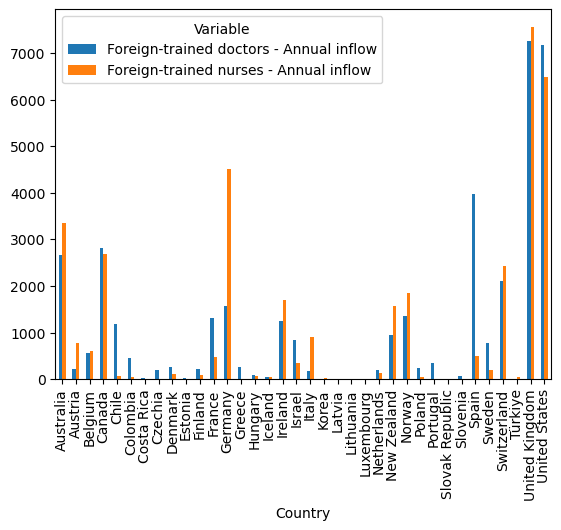

In [19]:
summary_imm = pd.DataFrame (worker_migr.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)
summary_imm.plot.bar()

/tmp/ipykernel_494/3391833860.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary_imm = pd.DataFrame (worker_migr_2_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)


<AxesSubplot: xlabel='Country'>

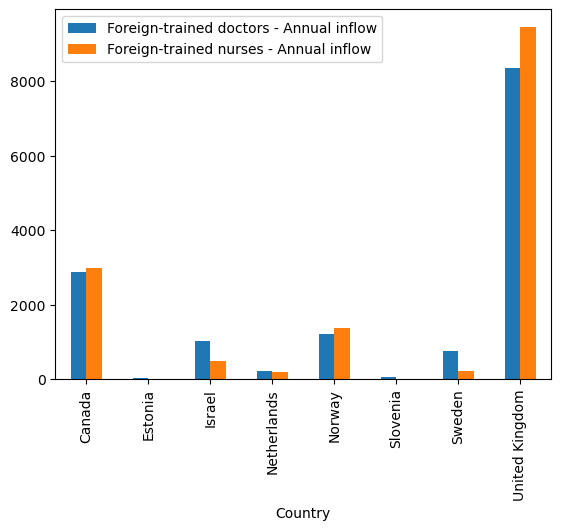

In [20]:
summary_imm = pd.DataFrame (worker_migr_2_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)
summary_imm.plot.bar()

In [21]:
per_capita_gdp = pd.DataFrame( reference["/capita, US$ purchasing power parity"]["Gross domestic product (GDP)"])
per_capita_gdp = per_capita_gdp[per_capita_gdp.index.get_level_values('Year') > 2014]
per_capita_gdp_filtered = per_capita_gdp[per_capita_gdp.index.get_level_values('Country').isin(common_countries)]

per_capita_gdp_summary = pd.DataFrame(per_capita_gdp_filtered.groupby(['Country'])['Gross domestic product (GDP)'].mean()).rename(columns={'Gross domestic product (GDP)': 'GDP per Capita by US$ purchasing power parity'})


In [22]:
imm_qual = pd.merge(summary_qual_hos, summary_qual_re_hos, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_qual_mor, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_imm, on = ['Country'])
imm_qual = pd.merge(imm_qual, per_capita_gdp_summary, on = ['Country'])
imm_qual = pd.merge(imm_qual, age_summary, on = ['Country']) 

NameError: name 'summary_qual_hos' is not defined

In [ ]:
correlation_matrix = imm_qual.corr()

In [ ]:
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Between Health Outcomes and Healthcare Professionals Migration')

plt.show()

In [ ]:
from sklearn import linear_model


X = imm_qual[["Hospital Admission","Hospital Readmission", "Mortality", "GDP per Capita by US$ purchasing power parity", "Population: 65 years old and over"]]
y = imm_qual['Foreign-trained doctors - Annual inflow'] 

X = sm.add_constant(X)
doc_imm_model = sm.OLS(y, X)
doc_imm_result = doc_imm_model.fit()

print(doc_imm_result.summary())

## Results
Countries with a higher number of mortality, hospital admission, and readmission tend to have a lower number of migrant healthcare providers. However, this may be attributed to  

## Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration

**Preliminary Analysis**

Had to remove GP salary due to lack of data

In [ ]:
hlth_gdp_share = health_expen["Share of gross domestic product"]["Current expenditure on health (all functions)"]
inpt_gdp_share = health_expen["Share of gross domestic product"]["Inpatient curative and rehabilitative care"]
prev_gdp_share = health_expen["Share of gross domestic product"]["Preventive care"]
hlth_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Current expenditure on health (all functions)"]
inpt_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Inpatient curative and rehabilitative care"]
prev_percap_ppp = health_expen["Per capita, current prices, current PPPs"]["Preventive care"]
gp_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of general practitioners"]
nur_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of specialists"]
hosp_doc_pct = health_resor["% of total hospital employment (head counts)"]["Physicians employed in hospitals"]
hosp_nurmw_pct = health_resor["% of total hospital employment (head counts)"]["Professional nurses and midwives employed in hospitals"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
pop_cov_pct = social_proc["% of total population covered"]["Total public and primary voluntary health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
for_doc_inf = worker_migr["Foreign-trained doctors - Annual inflow"]
for_nur_inf = worker_migr["Foreign-trained nurses - Annual inflow"]

In [ ]:
doc_pct_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_doc_pct,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_pct]
doc_pct_pred = pd.concat(doc_pct_pred_list,axis=1).dropna()
doc_pct_pred_corr = doc_pct_pred.corr()["% of foreign-trained doctors"]

doc_inf_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_doc_pct,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_inf]
doc_inf_pred = pd.concat(doc_inf_pred_list,axis=1).dropna()
doc_inf_pred_corr = doc_inf_pred.corr()["Foreign-trained doctors - Annual inflow"]

nur_pct_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_nurmw_pct,nur_sal_usd,gov_hi_pct,for_nur_pct]
nur_pct_pred = pd.concat(nur_pct_pred_list,axis=1).dropna()
nur_pct_pred_corr = nur_pct_pred.corr()["% of foreign-trained nurses"]

nur_inf_pred_list = [hlth_gdp_share,inpt_gdp_share,prev_gdp_share,hlth_percap_ppp,inpt_percap_ppp,prev_percap_ppp,hosp_nurmw_pct,nur_sal_usd,gov_hi_pct,for_nur_inf]
nur_inf_pred = pd.concat(nur_inf_pred_list,axis=1).dropna()
nur_inf_pred_corr = nur_inf_pred.corr()["Foreign-trained nurses - Annual inflow"]

In [ ]:
print("Percentage of foreign-trained doctors \n" + str(doc_pct_pred_corr)+"\n")
print("Inflow of foreign-trained doctors \n" + str(doc_inf_pred_corr)+"\n")
print("Percentage of foreign-trained nurses \n" + str(nur_pct_pred_corr)+"\n")
print("Inflow of foreign-trained nurses \n" + str(nur_inf_pred_corr)+"\n")

In [ ]:
doc_inf_pred.plot("Preventive care","Foreign-trained doctors - Annual inflow","scatter")

In [ ]:
x_docinf = doc_inf_pred.loc[:,~doc_inf_pred.columns.isin(["% of foreign-trained doctors"])]
y_docinf = doc_inf_pred["Foreign-trained doctors - Annual inflow"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docinf_model.fit()

print(x_docinf_result.summary())

In [ ]:
x_docinf = doc_inf_pred[["Current expenditure on health (all functions)","Remuneration of general practitioners","Remuneration of specialists","Government/compulsory health insurance coverage"]]
y_docinf = doc_inf_pred["Foreign-trained doctors - Annual inflow"]

x_docinf = sm.add_constant(x_docinf)
x_docinf_model = sm.OLS(y_docinf, x_docinf)
x_docinf_result = x_docpct_model.fit()

print(x_docinf_result.summary())

## Relationship Between Domestic and Foreign-Trained Medical Professionals

In [23]:
#create new column for percentage of domestically trained healthcare workers
#sum domestic trained doctors and nurses, divide by total
worker_migr['%_of_domestic_trained_healthcare_workers'] = (
    (worker_migr['Domestically-trained doctors'] + worker_migr['Domestically-trained nurses']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100

worker_migr['%_of_foreign_trained_healthcare_workers'] = (
    (worker_migr['Foreign-trained doctors - Stock'] + worker_migr['Foreign-trained nurses - Stock']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100


#worker_migr['%_of_workers_unknown_training'] = 100 - (worker_migr['%_of_foreign_trained_healthcare_workers']\
                                                    #+ worker_migr['%_of_domestic_trained_healthcare_workers'])


# Reset index
worker_migr= worker_migr.reset_index()

In [24]:
worker_migr.head()

Variable,Year,Country,% of foreign-trained doctors,% of foreign-trained nurses,Domestically-trained doctors,Domestically-trained nurses,Foreign-trained doctors - Annual inflow,Foreign-trained doctors - Stock,Foreign-trained nurses - Annual inflow,Foreign-trained nurses - Stock,Total number of doctors,Total number of nurses,Unknown place of training (doctors),Unknown place of training (nurses),of which native-born but foreign-trained (doctors),of which native-born but foreign-trained (nurses),%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers
0,2010,Austria,3.900,NaN,31753.0,NaN,191.0,1289.0,NaN,NaN,33042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Belgium,8.200,1.46,49038.0,163140.0,504.0,4380.0,361.0,2419.0,53418.0,165559.0,NaN,NaN,NaN,NaN,96.895108,3.104892
2,2010,Canada,23.197,7.22,62059.0,327399.0,2437.0,18765.0,2333.0,25635.0,80895.0,354918.0,71.0,1884.0,NaN,NaN,89.363557,10.187856
3,2010,Costa Rica,NaN,NaN,NaN,NaN,15.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,Czechia,4.400,NaN,40740.0,NaN,103.0,1874.0,NaN,NaN,42614.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
worker_migr_to_plot = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',\
                                   '%_of_foreign_trained_healthcare_workers',"% of foreign-trained doctors"
                                  ]] \
                        .groupby('Country') \
                        .mean() \
                        .dropna()\
                        .reset_index()\

worker_migr_to_plot.head()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers,% of foreign-trained doctors
0,Australia,2016.5,75.906449,21.387244,32.110500
1,Austria,2016.0,89.054196,10.917625,5.476923
2,Belgium,2016.0,94.815600,5.184400,11.479231
3,Canada,2015.5,88.293546,11.062368,24.073833
4,Chile,2016.5,89.164194,10.704136,20.578889


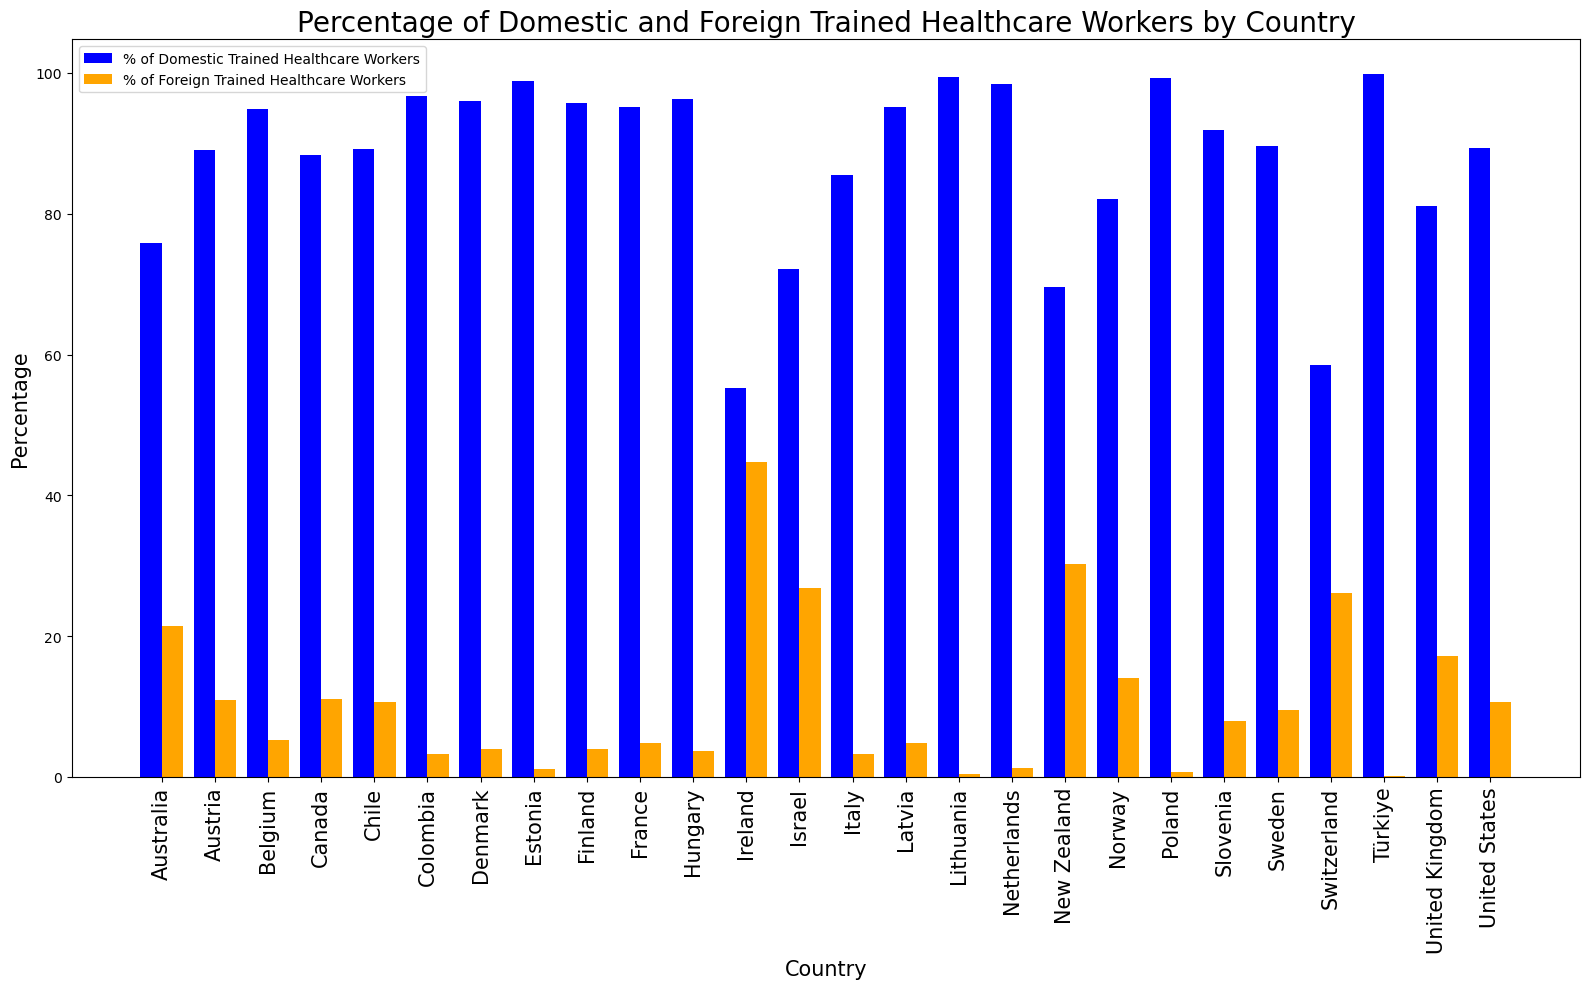

In [27]:
bar_width = 0.4

# bar positions
r1 = np.arange(len(worker_migr_to_plot['Country']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(16, 10))

#domestic healthcare workers
plt.bar(r1, worker_migr_to_plot['%_of_domestic_trained_healthcare_workers'], color='blue', width=bar_width, label='% of Domestic Trained Healthcare Workers')

#foreign healthcare workers
plt.bar(r2, worker_migr_to_plot['%_of_foreign_trained_healthcare_workers'], color='orange', width=bar_width, label='% of Foreign Trained Healthcare Workers')

plt.xticks([r + bar_width/2 for r in range(len(worker_migr_to_plot['Country']))], worker_migr_to_plot['Country'], rotation=90, size = 15)

plt.xlabel('Country', size = 15)
plt.ylabel('Percentage', size = 15)
plt.title('Percentage of Domestic and Foreign Trained Healthcare Workers by Country', size = 20)
plt.legend()
plt.tight_layout()
plt.show()

## Maps

**Map of doctor inflow, map of foreign doctor percentage, map of nurse inflow, map of foreign nurse percentage**

In [28]:


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Replace 'United States of America' with 'United States' and 'Turkey' with 'Türkiye'
world['name'] = world['name'].replace({'United States of America': 'United States', 'Turkey': 'Türkiye'})



# Merge the world shapefile with your data
merged_data = world.merge(worker_migr_to_plot, how='left', left_on='name', right_on='Country')

world.head()

/tmp/ipykernel_494/525216656.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


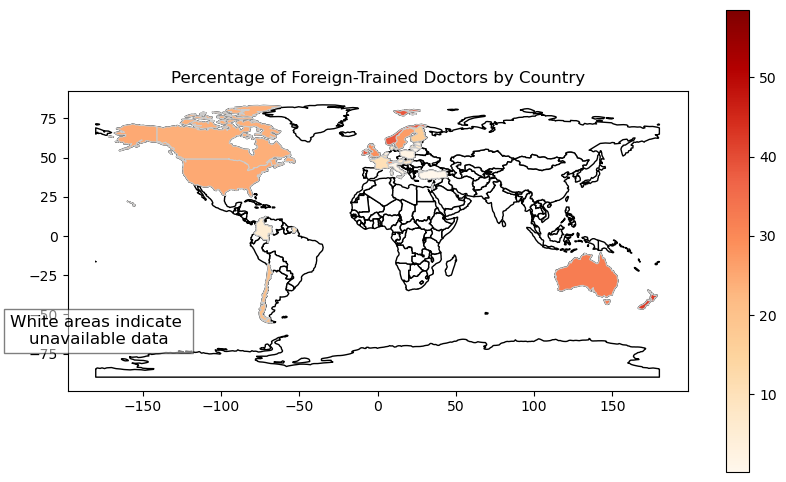

In [30]:
# Plot the world map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='white', edgecolor='black')

# Plot the data from merged_data
merged_data.plot(column='% of foreign-trained doctors', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add a note indicating that white areas represent unavailable data
ax.text(0.05, 0.2, 'White areas indicate \nunavailable data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax.set_title('Percentage of Foreign-Trained Doctors by Country')
plt.show()
